In [1]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A

from utils.visualize import visualize_bboxes
from utils.helper import fix_bounding_box


In [2]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2, format="xywh"):
    """Visualizes a single bounding box on the image"""
    if format == "xywh":
        x_c, y_c, w, h, dw, dh = bbox

        x_min = int((x_c - w/2) * dw)
        x_max = int((x_c + w/2) * dw) 
        y_min = int((y_c - h/2) * dh)      
        y_max = int((y_c + h/2) * dh)

        print(x_min, y_min, x_max, y_max)
    else:
        x_min, y_min, x_max, y_max = bbox
        x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, format="xywh"):
    color_list = {
        "table": (0,255,0),
        "ref": (255,0,0),
        "object": (0,0,255),
    }
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name, color_list[class_name], format=format)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [3]:
filename = "../datasets/data/dalemkotak/WIN_20240404_15_42_15_Pro"
image = cv2.imread(filename + '.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape
image_viz = image.copy()

In [7]:
# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {
    0: 'table', 
    1: 'ref', 
    2: 'object'
}

In [5]:
def convert_and_normalize_bbox(bbox, image_size):
  """Converts bounding box format and normalizes coordinates.

  Args:
    bbox: A list of bounding box coordinates in the format [xmin, ymin, xmax, ymax].
    image_size: A tuple representing the image size in the format (height, width).

  Returns:
    A list of normalized bounding box coordinates in the format [x_center, y_center, width, height].
  """

  xmin, ymin, xmax, ymax = bbox
  # im_width, im_height = image_size
  im_height, im_width = image_size

  x_center = ((xmax - xmin)/2 + xmin)/im_width 
  y_center = ((ymax - ymin)/2 + ymin)/im_height
  # x_center = ((xmax + xmin) / 2) / im_width  # <-- Calculate center relative to image width
  # y_center = ((ymax + ymin) / 2) / im_height  # <-- Calculate center relative to image height
  width = (xmax - xmin)/im_width
  height = (ymax - ymin)/im_height

  return [x_center, y_center, width, height]

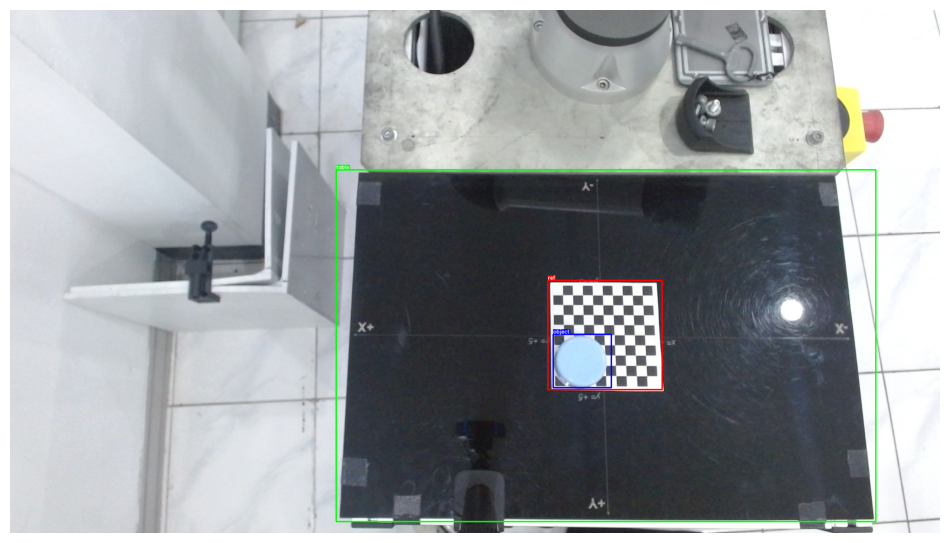

In [10]:
visualize(image_viz, bboxes, category_ids, category_id_to_name, format="xyxy")

[0, 1, 2]
[[673.2530120481927, 331.5662650602409, 1787.7108433734938, 1056.8674698795176], [1110.6024096385543, 559.277108433735, 1346.7469879518071, 784.5783132530121], [1121.4457831325299, 670.1204819277109, 1241.9277108433732, 780.9638554216867]]
AFTER NORMALIZE BBOX
[[0.6408760040160641, 0.6427933958054437, 0.5804467871485943, 0.6715751896474784], [0.6399347389558232, 0.6221552878179384, 0.12299196787148586, 0.20861222668451587], [0.6154618473895581, 0.6717983043284248, 0.06275100401606425, 0.10263275323516281]]
AFTER DENORMALIZE BBOX
676 331 1791 1056
1076 559 1312 784
1229 670 1350 780


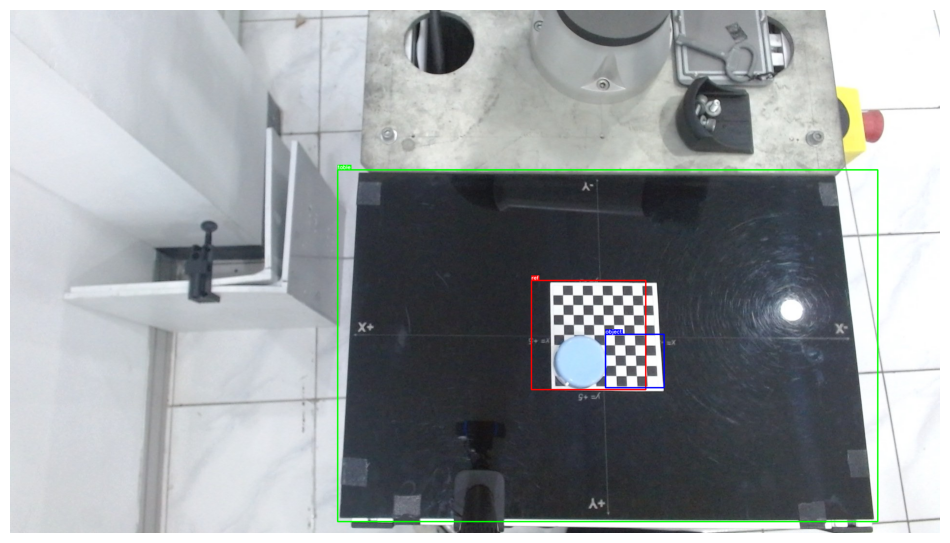

In [8]:
with open(filename + ".txt", "r") as f:
    lines = f.readlines()
    
bboxes = [[float(x) for x in line.split(",")[:4]] for line in lines]
norm_bboxes = [convert_and_normalize_bbox(bb, (image_h, image_w)) for bb in bboxes] # convert to yolo

categories = [line.strip().split(",")[-1] for line in lines]
category_ids = [list(category_id_to_name.keys())[list(category_id_to_name.values()).index(name)] for name in categories]

print(category_ids)
print(bboxes)
print("AFTER NORMALIZE BBOX")
print(norm_bboxes)
print("AFTER DENORMALIZE BBOX")
new_bboxes = [[bbox[1], bbox[1], bbox[2], bbox[3], image_w, image_h] for bbox in norm_bboxes]
# visualize(image_viz, bboxes, category_ids, category_id_to_name, format="xyxy")
visualize(image_viz, new_bboxes, category_ids, category_id_to_name, format="xywh")

In [ ]:
x_min, y_min, w, h, img_w, img_h = bboxes

In [10]:
transform = A.Compose([
        A.RandomBrightnessContrast(p=0.7),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.7),
        A.GaussNoise(p=0.7),
        A.GaussianBlur(p=0.7),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

In [12]:
bboxes

[[721.4457831325301, 337.5903614457831, 1829.879518072289, 1049.6385542168675],
 [1151.566265060241, 562.8915662650603, 1397.3493975903614, 785.7831325301205],
 [1208.1927710843374,
  617.1084337349398,
  1331.0843373493976,
  730.3614457831326]]

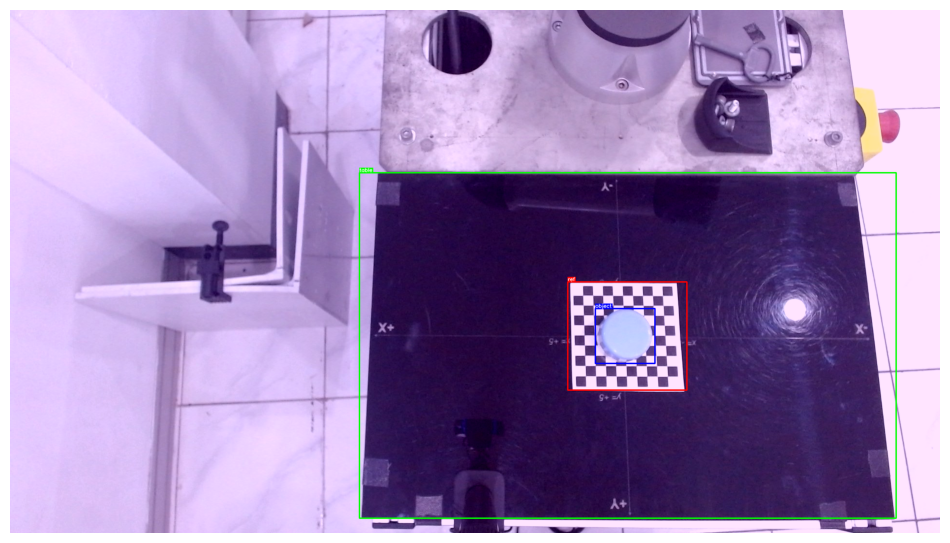

In [14]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
    format='xyxy',
)

In [16]:
transformed.keys()

dict_keys(['image', 'bboxes', 'category_ids'])

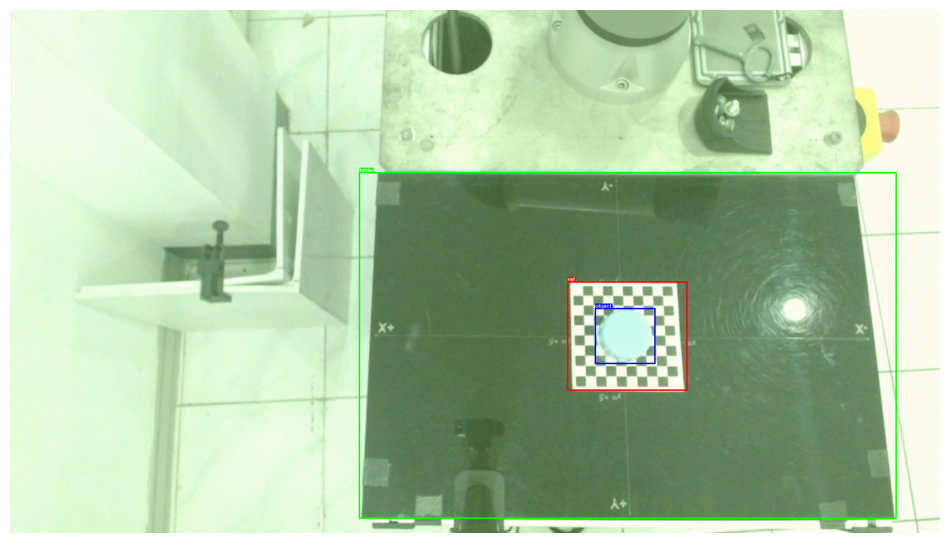

In [ ]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

In [ ]:
transformed['category_ids']

[0, 1, 2]

# Inference preparation

In [2]:
from pathlib import Path
import torch
import cv2
import numpy as np

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

from ultralyticsmod.utils.plotting import AnnotatorMeasurement

import sys
sys.path.append("C:\Others\yolov5")

from utils.torch_utils import select_device, smart_inference_mode
from models.common import DetectMultiBackend
from utils.general import (
   check_img_size,
   Profile,
   increment_path,
   non_max_suppression,
   scale_boxes,
)
from utils.dataloaders import LoadImages
from ultralytics.utils.plotting import Annotator, colors, save_one_box


In [3]:
device = ""
weights = "C:\\Others\\yolov5\\runs\\train\\exp8\\weights\\best.pt"
dnn = False
data = "C:\\Others\\yolov5\\data\\v2.yaml",  # dataset.yaml path
half = False
imgsz = (640, 640)
augment = False

# Load model
device = select_device(device)
model = DetectMultiBackend(
    weights, 
    device=device, 
    dnn=dnn, 
    data=data, 
    fp16=half
)
stride, names, pt = model.stride, model.names, model.pt
imgsz = check_img_size(imgsz, s=stride)  # check image size

YOLOv5  v7.0-304-g22361691 Python-3.10.14 torch-2.2.2+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs


In [4]:
# Dataloader
bs = 1  # batch_size
vid_stride = 1,  # video frame-rate stride
source = "C:\\Others\\datasets\\augments\\test\\WIN_20240404_15_41_03_Pro0000.jpg" # file/dir/URL/glob/screen/0(webcam)
source = str(source)

dataset = LoadImages(
    source, 
    img_size=imgsz, 
    stride=stride, 
    auto=pt, 
    vid_stride=vid_stride
)
vid_path, vid_writer = [None] * bs, [None] * bs

In [5]:
# Run inference
model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))  # warmup
seen, windows, dt = 0, [], (Profile(device=device), Profile(device=device), Profile(device=device))

# Directories
project = "detects/" # save results to project/name
name = "exp/"  # save results to project/name
exist_ok = False  # existing project/name ok, do not increment
save_txt = False  # save results to *.txt

save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
(save_dir / "labels" if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir


# Inference

In [6]:
visualize = False  # visualize features
conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
classes = None  # filter by class: --class 0, or --class 0 2 3
agnostic_nms = False  # class-agnostic NMS
max_det = 1000  # maximum detections per image

for path, im, im0s, vid_cap, s in dataset:
    with dt[0]:
        im = torch.from_numpy(im).to(model.device)
        im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim
        if model.xml and im.shape[0] > 1:
            ims = torch.chunk(im, im.shape[0], 0)

    # Inference
    with dt[1]:
        visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
        if model.xml and im.shape[0] > 1:
            pred = None
            for image in ims:
                if pred is None:
                    pred = model(image, augment=augment, visualize=visualize).unsqueeze(0)
                else:
                    pred = torch.cat((pred, model(image, augment=augment, visualize=visualize).unsqueeze(0)), dim=0)
            pred = [pred, None]
        else:
            pred = model(im, augment=augment, visualize=visualize)
    # NMS
    with dt[2]:
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

In [8]:
line_thickness = 2  # bounding box thickness (pixels)
hide_conf = False  # hide confidences
hide_labels = False  # hide labels

# Process predictions
for i, det in enumerate(pred):  # per image
    p, im0, frame = path, im0s.copy(), getattr(dataset, "frame", 0)
    p = Path(p)  # to Path
    save_path = str(save_dir / p.name)  # im.jpg
    txt_path = str(save_dir / "labels" / p.stem) + ("" if dataset.mode == "image" else f"_{frame}")  # im.txt
    s += "%gx%g " % im.shape[2:]  # print string
    gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    annotator = AnnotatorMeasurement(im0, line_width=line_thickness, example=str(names))

    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

        # Print results
        for c in det[:, 5].unique():
            n = (det[:, 5] == c).sum()  # detections per class
            s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

        # Write results
        measurement = {
            "center": {},
            "units": {},
            "xyxy": {},
        }
        obj_color = {}
        for *xyxy, conf, cls in reversed(det):
            c = int(cls)  # integer class
            label = names[c] if hide_conf else f"{names[c]}"
            confidence = float(conf)
            confidence_str = f"{confidence:.2f}"
            obj_color[label] = colors(c, True)
            
            if label == "ref":
                # get units of measurement
                # measure length from center point
                unit_per_x = np.abs(xyxy[2] - xyxy[0])/10 # width box divided by 10
                unit_per_y = np.abs(xyxy[3] - xyxy[1])/10 # height box divided by 10
                measurement["units"]["x"] = unit_per_x
                measurement["units"]["y"] = unit_per_y


            # Add bbox to image
            c = int(cls)  # integer class
            label_conf = None if hide_labels else (names[c] if hide_conf else f"{names[c]} {conf:.2f}")
            annotator.box_label(xyxy, label_conf, color=colors(c, True))
            cx, cy = annotator.get_center(xyxy) # get center of box

            if label not in measurement["center"]:
                measurement["center"][label] = []
            measurement["center"][label].append((cx, cy)) # add center to measurement

            if label not in measurement["xyxy"]:
                measurement["xyxy"][label] = []
            measurement["xyxy"][label].append((xyxy[0], xyxy[1], xyxy[2], xyxy[3])) # add xyxy to measurement
            
        im0 = annotator.result()
        center_ref = measurement["center"]["ref"] # center reference (x, y)
        unit_x, unit_y = measurement["units"]["x"], measurement["units"]["y"]

        # Write real measurement result based on unit
        for label, centers in measurement["center"].items():
            # Only if object(s) is/are detected (also show the origin coordinate)
            if label == "object" or label == "ref":
                for c in centers:
                    # c: center of bounding box
                    # Write center points to image
                    im0 = cv2.circle(
                        im0, 
                        (int(c[0]),int(c[1])), 
                        radius=0, 
                        color=obj_color[label], 
                        thickness=5
                    )
                    # estimate coordinates of center
                    cx_scaled, cy_scaled = annotator.estimate_coordinate(
                        c,
                        center_ref[0],
                        (unit_x, unit_y),
                    )
                    im0 = cv2.putText(
                        im0,
                        f'[{round(cx_scaled,2)}, {round(cy_scaled,2)}]', 
                        (int(c[0]),int(c[1])),
                        fontFace=cv2.FONT_HERSHEY_COMPLEX, 
                        fontScale=1,
                        color=obj_color[label],
                        thickness=line_thickness,
                        lineType=cv2.LINE_AA,
                    )
            # Show table size
            if label == "table":
                bbox = measurement["xyxy"][label][0]
                box_w, box_h = annotator.estimate_box_size(bbox, (unit_x, unit_y))
                # show width size
                im0 = cv2.putText(
                    im0,
                    f'TABLE SIZE: (WIDTH={round(box_w, 2)}, HEIGHT={round(box_h, 2)})', 
                    (
                        int(bbox[0] + 200),
                        int(bbox[1] - 2)
                    ),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale=1,
                    color=obj_color[label],
                    thickness=line_thickness,
                    lineType=cv2.LINE_AA,
                )
            
        # Save results (image with detection)
        cv2.imwrite(save_path, im0)


In [14]:
str(save_dir / "out.csv")

'detects\\exp9\\out.csv'